**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 1: Non-sequential architectures

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchinfo import summary
from math import ceil, sqrt
import numpy as np

/home/johannes/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
Transform = ToTensor()

train_data = datasets.CIFAR10(
    root = "../data",
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = "../data", 
    train = False, 
    transform = Transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

n_classes = len(train_data.classes)
input_size = (train_loader.batch_size, *train_data[0][0].shape)

In [4]:
def train(epoch, model, data_loader, log_interval=200):
    
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        pred = output.argmax(dim=1)
        
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{:5}/{:5} ({:2.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [5]:
@torch.inference_mode()
def validate(model, data_loader):
   
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        output = model(data)
        val_loss += criterion(output, target).item()
        
        pred = output.argmax(dim=1)
        total_correct += torch.sum(pred == target).item()
        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print("Validation set: Average loss: {:.4f}, Accuracy: {:5}/{:5} ({:2.2f}%)\n".format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

In [6]:
class NonSeqModel(nn.Module):
    def __init__(self, input_size, n_classes):
        super().__init__()
        conv_out_channels=32
        max_pool_kernel_size=2
        self.path1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=conv_out_channels,
                kernel_size=3,
                padding="same",
                stride=1,
            ),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel_size),
            nn.Flatten(),
        )
        self.path2 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=conv_out_channels,
                kernel_size=5,
                padding="same",
                stride=1,
            ),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel_size),
            nn.Flatten(),
        )
        self.path3 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=conv_out_channels,
                kernel_size=7,
                padding="same",
                stride=1,
            ),
            nn.BatchNorm2d(conv_out_channels),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_kernel_size),
            nn.Flatten(),
        )
        n_hidden_layer_neurons = 128
        self.fc = nn.Sequential(
            nn.Linear(np.prod(input_size[2:]) * conv_out_channels // max_pool_kernel_size**2 * 3,
                      n_hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_hidden_layer_neurons, n_hidden_layer_neurons),
            nn.BatchNorm1d(n_hidden_layer_neurons),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(n_hidden_layer_neurons, n_classes),
        )
        
    def forward(self, x):
        out1 = self.path1(x)
        out2 = self.path2(x)
        out3 = self.path3(x)
        return self.fc(torch.cat((out1, out2, out3), 1))

In [7]:
model = NonSeqModel(input_size, n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

summary(model, input_size=input_size)

Layer (type:depth-idx)                   Output Shape              Param #
NonSeqModel                              [128, 10]                 --
├─Sequential: 1-1                        [128, 8192]               --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─BatchNorm2d: 2-2                  [128, 32, 32, 32]         64
│    └─ReLU: 2-3                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-4                    [128, 32, 16, 16]         --
│    └─Flatten: 2-5                      [128, 8192]               --
├─Sequential: 1-2                        [128, 8192]               --
│    └─Conv2d: 2-6                       [128, 32, 32, 32]         2,432
│    └─BatchNorm2d: 2-7                  [128, 32, 32, 32]         64
│    └─ReLU: 2-8                         [128, 32, 32, 32]         --
│    └─MaxPool2d: 2-9                    [128, 32, 16, 16]         --
│    └─Flatten: 2-10                     [128, 8192]               --
├─Sequentia

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter("/tmp/pytorchlogs/")
writer.add_graph(model, next(iter(train_data))[0].reshape(1, 3, 32, 32))
writer.close()
# open tensorboard (tensorboard --logdir /tmp/pytorchlogs/) and save network graph as png

In [9]:
%%time

epochs = 10

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.486805
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.408239


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1995, Accuracy:  5663/10000 (56.63%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 1.394918
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.113331


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0878, Accuracy:  6197/10000 (61.97%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 1.056654
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.877453


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0421, Accuracy:  6341/10000 (63.41%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 0.899178
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.818551


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0611, Accuracy:  6287/10000 (62.87%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 0.826377
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.912180


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.1302, Accuracy:  5970/10000 (59.70%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 0.752494
Train Epoch: 6 [25600/50000 (51%)]	Loss: 0.833472


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9915, Accuracy:  6559/10000 (65.59%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 0.721602
Train Epoch: 7 [25600/50000 (51%)]	Loss: 0.607566


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.0633, Accuracy:  6385/10000 (63.85%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 0.595676
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.803232


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9804, Accuracy:  6791/10000 (67.91%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 0.554223
Train Epoch: 9 [25600/50000 (51%)]	Loss: 0.736881


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 0.9848, Accuracy:  6778/10000 (67.78%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 0.556412
Train Epoch: 10 [25600/50000 (51%)]	Loss: 0.409137


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 1.4337, Accuracy:  5915/10000 (59.15%)

CPU times: user 27min 57s, sys: 50.9 s, total: 28min 48s
Wall time: 5min 18s


train acc.: 80.4%
test acc.:  67.9%


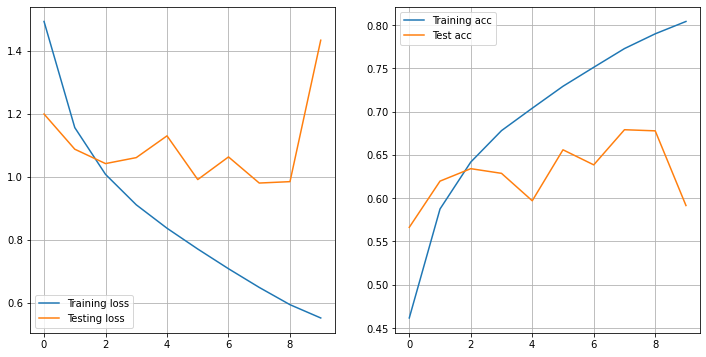

In [10]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

print(f"train acc.: {max(train_accuracies)*100:.3}%")
print(f"test acc.:  {max(val_accuracies)*100:.3}%")

| Model | Acc. train [%] | Acc. test [%] |
|-------|----------------|---------------|
| 1     | 75.0           | 66.1          |
| 2     | 82.9           | 67.1          |
| 3     | 80.4           | 67.9          |

## Netowork Visualizations from Tensorboard

### Model 1
| | |
|-|--|
| neurons in linear layers | 64 |
| conv kernel size | 3, 5 |
| conv output channels | 32 |
| maxpool kernel size | 2 |
| no dropout ||
| no batchnorm ||
![Model 1](./PW-14_exercise_1_graph1.png)
### Model 2
| | |
|-|--|
| neurons in linear layers | 128 |
| conv kernel size | 3, 5 |
| conv output channels | 32 |
| maxpool kernel size | 2 |
| dropout | .2 |
| no batchnorm ||
![Model 2](./PW-14_exercise_1_graph2.png)
### Model 3
| | |
|-|--|
| neurons in linear layers | 128 |
| conv kernel size | 3, 5, 7 |
| conv output channels | 32 |
| maxpool kernel size | 2 |
| dropout | .2 |
| batchnorm ||
![Model 3](./PW-14_exercise_1_graph3.png)